# 3D analysis of sequential DNA-FISH data (Hi-M) with pyHiM

This notebook demonstrates the basic usage of pyHiM and explains each aspect of the analysis of sequential DNA-FISH data. Test datasets can be downloaded [here](enterthelocationhere):
    
The notebook is decomposed into 6 sections that illustrate each aspect of the analysis.

    - Section 0 : Selection of dataset 
    - Section 1 : Creation of Z-projections
    - Section 2 : Global 2D registration
    - Section 3 : Local 3D registration
    - Section 4 : Segmentation and localization
    - Section 5 : Building chromatin traces and pair-wise distance matrices

In [8]:
# Import python packages
from Jupyter_functions_plots import *
import os

# Enable inline plots
%matplotlib inline

In [9]:
# Basic check of PyHiM installation 
! pyhim --help

usage: pyhim [-h] [-F ROOTFOLDER] [-C CMD] [--threads THREADS]

options:
  -h, --help            show this help message and exit
  -F ROOTFOLDER, --rootFolder ROOTFOLDER
                        Folder with images
  -C CMD, --cmd CMD     Comma-separated list of routines to run (order matters
                        !): makeProjections alignImages appliesRegistrations
                        alignImages3D segmentMasks segmentMasks3D
                        segmentSources3D buildHiMmatrix optional: [
                        filter_localizations register_localizations
                        build_traces build_matrix]
  --threads THREADS     Number of threads to run in parallel mode. If none,
                        then it will run with one thread.


<div class="alert alert-block alert-info">
For more information please refer to the <a href="https://pyhim.readthedocs.io/en/latest/user_guide/pyhim_presentation.html">Online Documentation</a> </div>  


## Section 0/5: Selection of dataset

In this section, you will select the dataset that pyHiM will analyze during the execution of this notebook. 
    
- Dataset 0 "Full" : Full dataset containing 17 cycles. 

- Dataset 1 "Reduced" : Reduced dataset containing 2 cycles

These datasets were acquired with [Qudi-HiM](https://s3-eu-west-1.amazonaws.com/openreseurope/manuscripts/15811/8defa23f-d865-4af0-9878-e45a6f4e67c6_14641_-_marcelo_nollmann_(1).pdf?doi=10.12688/openreseurope.14641.1&numberOfBrowsableCollections=68&numberOfBrowsableInstitutionalCollections=0&numberOfBrowsableGateways=9) (Barho et al. 2022).     

The input datasets contain:
- a DAPI image of nuclei (collected at 405 nm): scan_006_DAPI_001_ROI_converted_decon_ch00.tif
- the corresponding fiducial for the DAPI image (collected at 561 nm): scan_006_DAPI_001_ROI_converted_decon_ch01.tif

These 3D images are collected only once per region of interest (ROI).
    
- barcode image for cycle `RTX` (collected at 647nm):scan_001_RTX_001_ROI_converted_decon_ch01.tif           
- the corresponding fiducial for cycle `RTX` (collected at 561nm): scan_001_RTX_001_ROI_converted_decon_ch00.tif 

These 3D images are collected for each cycle of hybridization, for each ROI.


In [10]:
# Indicate the directory that contain the dataset to use
Root_folder ='/home/marcnol/grey/DATA/users/marcnol/test_HiM/olivier_pancreas/rawData_2022_Exp6_ROI5/'
print(f"The current working directory: {os.path.abspath(os.curdir)}")

dataset = 'Reduced' #Option : 'Full' or 'Reduced'
Input_folder = dataset_to_use(Root_folder,dataset)
os.chdir(Input_folder)

print(f"The current working directory: {os.path.abspath(os.curdir)}")

The current working directory: /mnt/grey/DATA/users/marcnol/test_HiM/olivier_pancreas/rawData_2022_Exp6_ROI5/Input_datatest_subset
The current working directory: /mnt/grey/DATA/users/marcnol/test_HiM/olivier_pancreas/rawData_2022_Exp6_ROI5/Input_datatest_subset


## Section 1/5: Creation of Z-projections

    
The `makeProjections` module with project the 3D input images in 2D, using the method specified in the `infoList.json` file (default: maximum intensity projection). This step is required for the registration of XY mechanical shifts, and for 2D segmentations.


In [11]:
%%capture 
#To hide the terminal outputs, uncomment if you want to display them

# Execute makeProjections 
! pyhim -C makeProjections

### DAPI projections

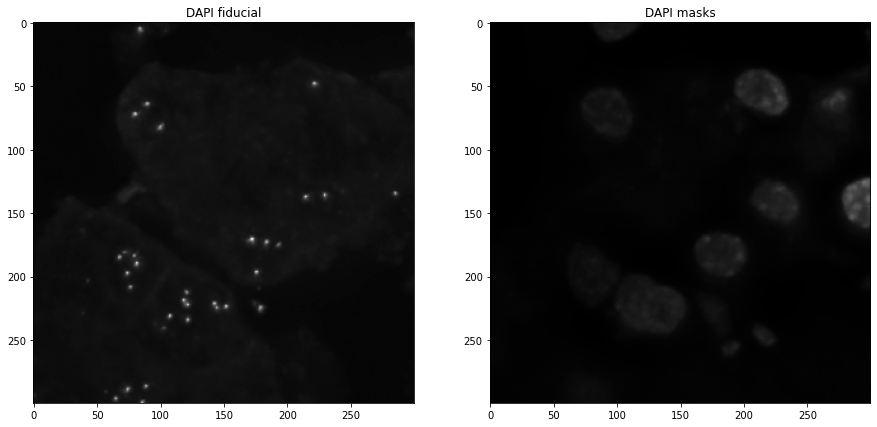

In [12]:
# Set datatype ('DAPI','RT')
datatype = 'DAPI'

# Set titles 
titles = ['DAPI fiducial','DAPI masks']

# Display DAPI and fiducial signal   
plot_zprojection(Input_folder,_,titles,datatype)

### Barcode projections

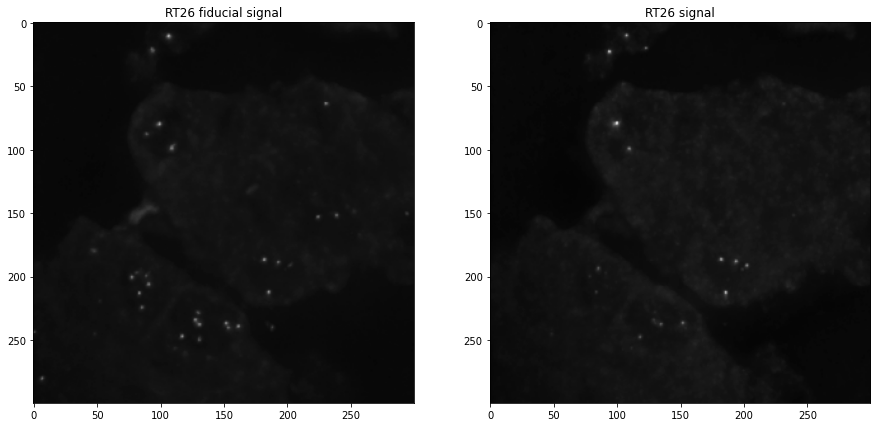

In [13]:
# Set datatype ('DAPI','RT')
datatype = 'RT'

# Set reference RTs
RTs_references = 'RT26' 

# Set titles 
titles = [RTs_references+' fiducial signal',RTs_references+' signal']

# Display RTs and fiducial signal        
plot_zprojection(Input_folder,RTs_references,titles,datatype)

## Section 2/5: Registration

This section will use fiducial images to register images to correct the mechanical drift of the microscope. For this, a reference barcode fiducial needs to be provided in the infoList.json file. The `alignImages` method will find the shifts in XY that best registers the fiducial images. The `appliesRegistrations` method will apply these shifts to the DAPI and barcode images. Different methods for global alignment are available, please see the [alignImages user documentation](https://pyhim.readthedocs.io/en/latest/user_guide/fundamental.html#alignimages) for more imformation.

In [14]:
%%capture
# Indicate the directory that contains the test dataset
os.chdir(Input_folder)

# Execute the alignment 
! pyhim -C alignImages,appliesRegistrations

### Displaying results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


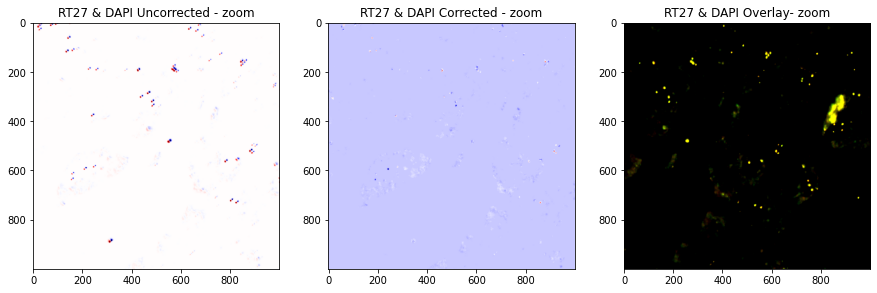

In [15]:
# Set figure titles
cycle = 'RT27'
titles = [cycle+' & DAPI '+'Uncorrected - zoom',cycle+' & DAPI '+'Corrected - zoom',cycle+' & DAPI '+'Overlay- zoom']

# Display alignement results 
plot_alignement(Input_folder,cycle,titles)

The left panel contains the difference between the fiducial image of the reference barcode (RT26, red) and the fiducial of the DAPI image (blue). The middle panel contains same difference image but for drift registered images. In this middle map, red and blue spots should disappear if images were correctly registered. The right panel shows the two registered images in RGB. Regions of perfect co-localization appear in yellow.  

## Section 3/5: Local 3D registration

This section will try to improve the global 2D registration from the previous module by taking into account local deformations of the sample. In addition, this function will check and correct residual Z-drifts that may have ocurred despite the use of an auto-focus control system. Different methods and options are available, please see the [alignImages3D user documentation](https://pyhim.readthedocs.io/en/latest/user_guide/fundamental.html#alignimages3d) for more imformation.

In [16]:
%%capture

! pyhim -C alignImages3D

In [6]:
#### Displaying results

SHOW PNG RESULT IMAGES !

## Section 4/5: Mask segmentation and barcode localization

This section will process the segmentation of nuclei images using AI-based methods. For more details, see the [segmentMasks3D user guide](https://pyhim.readthedocs.io/en/latest/user_guide/fundamental.html#segmentmasks3d). 

In [17]:
%%capture

! pyhim -C segmentMasks3D

### Displaying results


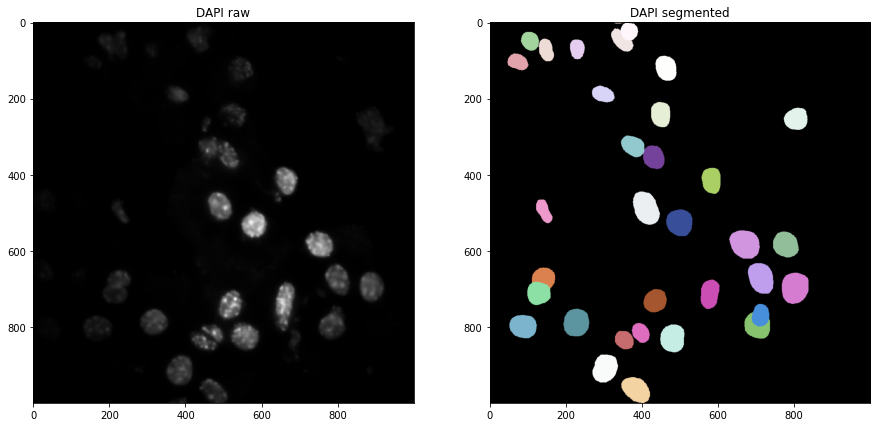

In [18]:
# Set datatype ('DAPI','RT','TRACES')
datatype = 'DAPI'

# Set titles
titles = ['DAPI raw','DAPI segmented']

# Display segmented DAPI masks
plot_segment_object(Input_folder,_,titles,datatype)

### Segmentation and 3D localization of barcodes

This section will segment barcodes using AI-based methods and then localize the center of each barcode using 3D gaussian fitting. For more details, see the [segmentSources3D user guide](https://pyhim.readthedocs.io/en/latest/user_guide/fundamental.html#segmentsources3d). 

In [19]:
%%capture

! pyhim -C segmentSources3D

### Displaying results

In [ ]:
# NEEDS TO BE VERIFIED!!

# Set datatype ('DAPI','RT','TRACES')
datatype = 'RT'

# Set titles
titles = [RTs_references+' Segmented ',RTs_references+' Segmented Zoom']

# Display segmented RTs masks
plot_segment_object(Input_folder,RTs_references,titles,datatype)

## Section 5/5: Building chromatin traces and pair-wise distance matrices

This section will build chromatin trace tables from the barcode localization tables, and from these calculate  pairwise distance (PWD) matrices for each trace.

==HERE WE NEED TO MAKE IT LOAD A GOOD TABLE OF LOCALIZATIONS AND MASKS SO THAT THE RESULTS ARE NOT FROM 2 BARCODES...==

### Building chromatin traces and Hi-M map

In [ ]:
%%capture

# Xavier: NEED TO VERIFY THAT process_segmentMasks3D can be called ! 

# Execute the matrix
! process_segmentMasks3D.py
! pyhim -C  filter_localizations,register_localizations,build_traces,build_matrix

#### Displaying chromatin traces

In [ ]:
# Set datatype ('DAPI','RT','TRACES')
datatype = 'TRACES'

# Set titles
titles = ['Traces','Traces zoomed']

# Display segmented traces
plot_segment_object(Input_folder,_,titles,datatype)

### Displaying proximity matrix

In [ ]:
# Display the 2D PWD matrix 
plot_matrix(Input_folder)